In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import sys, os, glob, time, warnings, gc
import healpy as hp

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
# x = np.linspace(-30, 30, 61)
# y = np.linspace(-30, 30, 61)
x = np.linspace(-15, 15, 31)
y = np.linspace(-15, 15, 31)
xx, yy = np.meshgrid(x, y)

In [4]:
pixel_size = 0.262

__Moffat profile__

In [5]:
def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    The integral (i.e., total flux) is unity by definition.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

NEA: 64.89788500314597
NEA in sq. arcsec.: 4.454850418155953


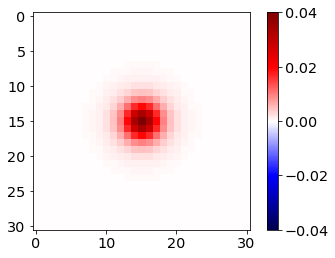

In [12]:
alpha_in_arcsec = 0.9
beta = 2.5
alpha_in_pixel = alpha_in_arcsec/pixel_size
fwhm_in_pixel = alpha_in_pixel * 2 * np.sqrt(2**(1/beta)-1)

img_moffat = get_sb_moffat(np.sqrt(xx**2+yy**2), alpha_in_pixel, beta)
img_moffat /= np.sum(img_moffat)

nea = np.sum(img_moffat)**2/np.sum(img_moffat**2) # in unit of number of pixels
print('NEA:', nea)
print('NEA in sq. arcsec.:', nea*pixel_size**2)

plt.imshow(img_moffat, vmin=-0.04, vmax=0.04, cmap='seismic')
plt.colorbar()
plt.show()

__Gaussian profile with the same FWHM__

Gaussian FWHM (arcsec): 1.0174505545254653
NEA: 34.1763636997363
NEA from analytic formula: 34.17636370003721


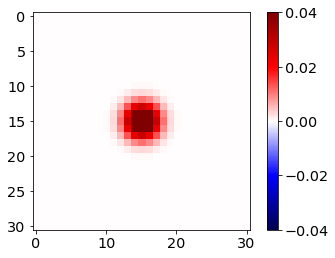

In [7]:
fwhm_in_arcsec = fwhm_in_pixel*pixel_size
print('Gaussian FWHM (arcsec):', fwhm_in_arcsec)
sigma_in_pixel = fwhm_in_pixel/2.3548

img_gaussian = np.exp(-(xx**2+yy**2)/(2*sigma_in_pixel**2))
img_gaussian /= np.sum(img_gaussian)

nea_gaussian_from_fwhm = np.sum(img_gaussian)**2/np.sum(img_gaussian**2) # in unit of number of pixels
print('NEA:', nea_gaussian_from_fwhm)

# Analytic formula for Gaussian profile
nea1 = 4 * np.pi * (sigma_in_pixel)**2
print('NEA from analytic formula:', nea1)

plt.imshow(img_gaussian, vmin=-0.04, vmax=0.04, cmap='seismic')
plt.colorbar()
plt.show()

__Sanity check: plot the 1-D profile normalized to peak intensity__

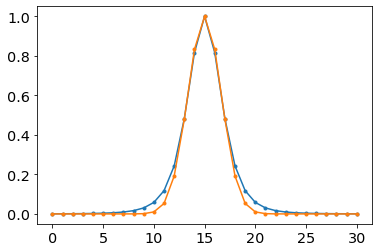

In [8]:
img_gaussian1 = img_gaussian / img_gaussian.max()
img_moffat1 = img_moffat / img_moffat.max()

plt.plot(img_moffat1[15], '.-', label='Moffat')
plt.plot(img_gaussian1[15], '.-', label='Gaussian')
plt.show()

__Fit Moffat with Gaussian profile with flexible amplitude and sigma__

In [9]:
gaussian_profile = lambda x, y, a, sigma_in_pixel: a*np.exp(-(x**2+y**2)/(2*sigma_in_pixel**2))

def chisq(params):
    a = params[0]
    sigma_in_pixel = params[1]
    return np.sum((img_moffat-gaussian_profile(xx, yy, a, sigma_in_pixel))**2)

from scipy.optimize import minimize
res = minimize(chisq, [img_moffat.max()*0.9, sigma_in_pixel])

a_best, sigma_in_pixel_best = res.x
print(a_best, sigma_in_pixel_best)
print(img_moffat.max(), sigma_in_pixel)

0.03630458105819402 1.9174413859480022
0.040775424854291205 1.649141779800533


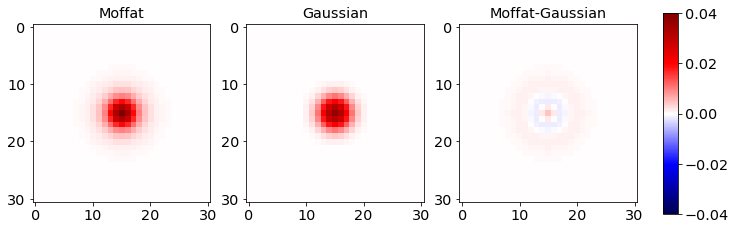

In [10]:
model_best = gaussian_profile(xx, yy, a_best, sigma_in_pixel_best)

# Plot image and residual
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
tmp = ax[0].imshow(img_moffat, vmin=-0.04, vmax=0.04, cmap='seismic')
ax[0].set_title('Moffat')
ax[1].imshow(model_best, vmin=-0.04, vmax=0.04, cmap='seismic')
ax[1].set_title('Gaussian')
ax[2].imshow(img_moffat-model_best, vmin=-0.04, vmax=0.04, cmap='seismic')
ax[2].set_title('Moffat-Gaussian')
fig.subplots_adjust(left=0.1, right=0.8)
cb_ax = fig.add_axes([0.83, 0.15, 0.017, 0.7])
cbar = fig.colorbar(tmp, cax=cb_ax)

plt.show()

In [11]:
nea_gaussian_bestfit = np.sum(model_best)**2/np.sum(model_best**2) # in unit of number of pixels
print('Moffat NEA:', nea)
print('Best-fit Gassuain NEA:', nea_gaussian_bestfit)
print('Fractional difference:', (nea_gaussian_bestfit-nea)/nea)

Moffat NEA: 64.89788500314597
Best-fit Gassuain NEA: 46.2012853276363
Fractional difference: -0.28809258845035307
